# Geographically Weighted Regression (Part I): COVID 19 Incidence

<b>Author:</b>  Naomi W. Lazarus, PhD<br>
<b>Date Created:</b> 6-14-21

This notebook provides the code for running a Geographically Weighted Regression (GWR) using COVID-19 incidence rates as the dependent variable and independent variables representing age and underlying conditions. It is an exploratory analysis of spatial relationships between COVID-19, age demographics, and comorbidities.  It is not recommended for predictive purposes.

# Notebook Outline

- [Introduction](#Intro)
    - [Install MGWR package](#Install)
    - [Load required packages](#Load)
- [Load and preview data for incidence rates for peak period 1](#Peak1)
    - [Preprocess data for GWR](#Data1)
    - [Review GWR Results](#Results1)
- [Load and preview data for incidence rates for peak period 2](#Peak2)
    - [Preprocess data for GWR](#Data2)
    - [Review GWR Results](#Results2)
- [References](#Ref)

<a id='Intro'></a>
# Introduction

The notebooks consists of two sections.  The first uses covid-19 incidence rates for peak period 1 (03/01/20 - 04/30/20).  The second uses covid-19 incidence rates for peak period 2 (06/01/20 - 07/31/20). The following links provide information on file descriptions and metadata. 

[Link to Metadata](Data_Files1/Metadata.txt)<br>
[Link to file descriptions](Data_Files1/Files.txt)


<a id='Install'></a>
## Install MGWR package

In [1]:
try:
    from mgwr.gwr import GWR
except:
    print('Installing MGWR')
    ! pip install -U mgwr


<a id='Load'></a>
## Load required packages

In [2]:
import numpy as np
import pandas as pd
import libpysal as ps
from spreg import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

<a id='Peak1'></a>
# Load and preview data for incidence rates for peak period 1

In [3]:
covid_IR1 = gp.read_file('/home/jovyan/shared_data/data/geospatialfellows21/lazarus_data/Data_Files1/Layer_IR1_1.shp')

In [4]:
covid_IR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,PCT_over75,DIAB_PCT,CARDIO_MR,OBESE_PCT,IR1_log,Shape_Leng,Shape_Area,X,Y,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,11.5,7.0,391.5,39.4,1.831404,153989.870317,1.481950e+09,-6.504090e+04,3.241203e+05,"POLYGON ((-84104.520 334058.032, -84103.729 33..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,11.7,10.3,326.0,34.7,1.648977,127476.552039,7.446410e+08,-2.088050e+06,1.126359e+06,"POLYGON ((-2090017.997 1120806.324, -2090461.7..."
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,5.4,8.1,186.9,29.9,1.876298,191498.450302,2.181031e+09,-5.775873e+04,1.982909e+05,"POLYGON ((-76484.353 198568.818, -76478.478 19..."
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,5.1,8.2,229.2,31.1,3.023345,186372.852811,2.103144e+09,-6.367993e+04,5.193930e+05,"POLYGON ((-71439.032 538818.414, -71405.569 53..."
4,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,...,7.8,9.4,342.9,37.7,1.467755,113442.973971,5.295929e+08,9.637362e+05,-1.947744e+05,"POLYGON ((954080.057 -191188.032, 954275.742 -..."


<a id='Data1'></a>
## Preprocess data for GWR

In [5]:
# Run Ordinary Least Squares Regression

y = covid_IR1['IR1_log'].values.reshape((-1, 1))
X = covid_IR1[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values

In [6]:
ols = OLS(y, X)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        2807
Mean dependent var  :      1.8743                Number of Variables   :           6
S.D. dependent var  :      0.5202                Degrees of Freedom    :        2801
R-squared           :      0.0555
Adjusted R-squared  :      0.0538
Sum squared residual:     717.126                F-statistic           :     32.9234
Sigma-square        :       0.256                Prob(F-statistic)     :   9.676e-33
S.E. of regression  :       0.506                Log likelihood        :   -2067.717
Sigma-square ML     :       0.255                Akaike info criterion :    4147.434
S.E of regression ML:      0.5054                Schwarz criterion     :    4183.074

-----------------------------------------------------------------------------

In [7]:
# Defining variables and coordinates

g_y = covid_IR1['IR1_log'].values.reshape((-1, 1))
g_X = covid_IR1[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values
u = covid_IR1['X']
v = covid_IR1['Y']
g_coords = list(zip(u, v))


In [8]:
# Inspecting the data contents

print('g_y:\n', g_y[:5])
print('\ng_X:\n', g_X[:5])
print('\nu:\n', list(u[:5]))
print('\nv:\n', list(v[:5]))
print('\ng_coords:\n', g_coords[:5], "\n")


g_y:
 [[1.83140432]
 [1.64897715]
 [1.87629805]
 [3.02334544]
 [1.46775536]]

g_X:
 [[ 31.9  11.5   7.  391.5  39.4]
 [ 44.3  11.7  10.3 326.   34.7]
 [ 24.7   5.4   8.1 186.9  29.9]
 [ 25.7   5.1   8.2 229.2  31.1]
 [ 32.    7.8   9.4 342.9  37.7]]

u:
 [-65040.9000187, -2088050.14619, -57758.7266368, -63679.9337388, 963736.215444]

v:
 [324120.335166, 1126359.47541, 198290.895484, 519393.038636, -194774.396232]

g_coords:
 [(-65040.9000187, 324120.335166), (-2088050.14619, 1126359.47541), (-57758.7266368, 198290.895484), (-63679.9337388, 519393.038636), (963736.215444, -194774.396232)] 



In [9]:
# Testing suitable bandwidth prior to specifying the model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)



102.0


In [10]:
# Specifying the GWR model - bandwidth set at 102 neighbors using an adaptive Gaussian kernal function

gwr_model = GWR(g_coords, g_y, g_X, bw=102, fixed=False, kernel='gaussian')
gwr_results = gwr_model.fit()


<a id='Results1'></a>
## Review GWR Results

In [11]:
# Print Global regression results

print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.R2)
print(gwr_results.adj_R2)

497.5393077277695
3274.3466280487974
0.3447157830553744
0.325102789515628


In [12]:
# Create a column to store R2 values in the dataframe

covid_IR1['R2'] = gwr_results.localR2   

In [13]:
covid_IR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DIAB_PCT,CARDIO_MR,OBESE_PCT,IR1_log,Shape_Leng,Shape_Area,X,Y,geometry,R2
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,7.0,391.5,39.4,1.831404,153989.870317,1.481950e+09,-6.504090e+04,3.241203e+05,"POLYGON ((-84104.520 334058.032, -84103.729 33...",0.107070
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,10.3,326.0,34.7,1.648977,127476.552039,7.446410e+08,-2.088050e+06,1.126359e+06,"POLYGON ((-2090017.997 1120806.324, -2090461.7...",0.206945
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,8.1,186.9,29.9,1.876298,191498.450302,2.181031e+09,-5.775873e+04,1.982909e+05,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.103294
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,8.2,229.2,31.1,3.023345,186372.852811,2.103144e+09,-6.367993e+04,5.193930e+05,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.124902
4,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,...,9.4,342.9,37.7,1.467755,113442.973971,5.295929e+08,9.637362e+05,-1.947744e+05,"POLYGON ((954080.057 -191188.032, 954275.742 -...",0.202185


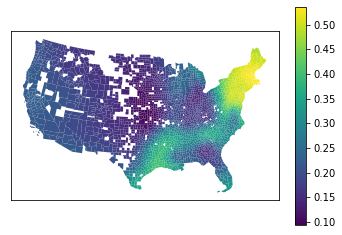

In [14]:
# Visualizing local R2 values on a map

covid_IR1['R2'] = gwr_results.localR2
covid_IR1.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Create a column to store standardized residual values in the dataframe

covid_IR1['SR'] = gwr_results.std_res

In [16]:
covid_IR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,CARDIO_MR,OBESE_PCT,IR1_log,Shape_Leng,Shape_Area,X,Y,geometry,R2,SR
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,391.5,39.4,1.831404,153989.870317,1.481950e+09,-6.504090e+04,3.241203e+05,"POLYGON ((-84104.520 334058.032, -84103.729 33...",0.107070,0.186783
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,326.0,34.7,1.648977,127476.552039,7.446410e+08,-2.088050e+06,1.126359e+06,"POLYGON ((-2090017.997 1120806.324, -2090461.7...",0.206945,0.733777
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,186.9,29.9,1.876298,191498.450302,2.181031e+09,-5.775873e+04,1.982909e+05,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.103294,-0.187736
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,229.2,31.1,3.023345,186372.852811,2.103144e+09,-6.367993e+04,5.193930e+05,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.124902,2.692081
4,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,...,342.9,37.7,1.467755,113442.973971,5.295929e+08,9.637362e+05,-1.947744e+05,"POLYGON ((954080.057 -191188.032, 954275.742 -...",0.202185,-0.739007


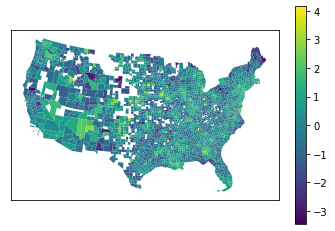

In [17]:
# Visualizing standardized residuals on a map

covid_IR1['SR'] = gwr_results.std_res
covid_IR1.plot('SR', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
# Reviewing parameter estimates associated with the predictors starting with the constant.
# B coefficients follow the sequence of predictors listed in code sample for running OLS

print(gwr_results.params)

[[ 2.44308643e+00 -1.67268326e-02 -1.18612977e-02 -1.20809756e-02
  -4.43367197e-04  6.03536058e-03]
 [ 2.84501495e+00 -1.30931699e-02 -1.30846267e-02 -1.91091199e-02
  -8.20776487e-04 -8.77443204e-03]
 [ 2.22257986e+00 -9.94843892e-03 -1.31924239e-02 -1.06409647e-02
  -7.13865665e-04  9.00354726e-03]
 ...
 [ 1.98114323e+00 -9.70352695e-04 -6.97662067e-02 -5.41841873e-03
  -2.22340329e-04  2.29916676e-02]
 [ 1.94957145e+00  4.25418331e-03 -3.35436249e-02 -5.56654204e-03
  -5.70721906e-04  4.46066728e-03]
 [ 2.59221745e+00 -2.00587208e-02  2.85294747e-02 -1.39577140e-02
  -9.08008198e-04 -1.26467092e-04]]


<a id='Peak2'></a>
# Load and preview data for incidence rates for peak period 2

In [19]:
covid_IR2 = gp.read_file('/home/jovyan/shared_data/data/geospatialfellows21/lazarus_data/Data_Files1/Layer_IR2_1.shp')

In [20]:
covid_IR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,PCT_over75,DIAB_PCT,CARDIO_MR,OBESE_PCT,IR2_log,Shape_Leng,Shape_Area,X,Y,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,11.5,7.0,391.5,39.4,2.451193,153989.870317,1.481950e+09,-65040.900019,324120.335166,"POLYGON ((-84104.520 334058.032, -84103.729 33..."
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,5.4,8.1,186.9,29.9,2.752805,191498.450302,2.181031e+09,-57758.726637,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19..."
2,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,14.0,5.6,548.3,35.6,1.984221,154088.963652,1.483452e+09,-173426.738663,132548.110644,"POLYGON ((-192849.850 123355.389, -192849.816 ..."
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,5.1,8.2,229.2,31.1,2.614508,186372.852811,2.103144e+09,-63679.933739,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53..."
4,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,None,...,11.2,7.0,342.1,29.1,2.874112,204909.652555,2.346750e+09,-366739.340990,-892066.944835,"POLYGON ((-365946.769 -870192.658, -365650.326..."


<a id='Data2'></a>
## Preprocess data for GWR

In [21]:
# Run Ordinary Least Squares Regression

y = covid_IR2['IR2_log'].values.reshape((-1, 1))
X = covid_IR2[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values

In [22]:
ols = OLS(y, X)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        3061
Mean dependent var  :      2.6156                Number of Variables   :           6
S.D. dependent var  :      0.4425                Degrees of Freedom    :        3055
R-squared           :      0.2311
Adjusted R-squared  :      0.2298
Sum squared residual:     460.654                F-statistic           :    183.6234
Sigma-square        :       0.151                Prob(F-statistic)     :  2.407e-171
S.E. of regression  :       0.388                Log likelihood        :   -1444.835
Sigma-square ML     :       0.150                Akaike info criterion :    2901.670
S.E of regression ML:      0.3879                Schwarz criterion     :    2937.829

-----------------------------------------------------------------------------

In [23]:
# Defining variables and coordinates

g_y = covid_IR2['IR2_log'].values.reshape((-1, 1))
g_X = covid_IR2[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values
u = covid_IR2['X']
v = covid_IR2['Y']
g_coords = list(zip(u, v))

In [24]:
# Inspecting the data contents

print('g_y:\n', g_y[:5])
print('\ng_X:\n', g_X[:5])
print('\nu:\n', list(u[:5]))
print('\nv:\n', list(v[:5]))
print('\ng_coords:\n', g_coords[:5], "\n")

g_y:
 [[2.45119307]
 [2.75280455]
 [1.98422124]
 [2.61450839]
 [2.87411228]]

g_X:
 [[ 31.9  11.5   7.  391.5  39.4]
 [ 24.7   5.4   8.1 186.9  29.9]
 [ 35.6  14.    5.6 548.3  35.6]
 [ 25.7   5.1   8.2 229.2  31.1]
 [ 38.1  11.2   7.  342.1  29.1]]

u:
 [-65040.9000187, -57758.7266368, -173426.738663, -63679.9337388, -366739.34099]

v:
 [324120.335166, 198290.895484, 132548.110644, 519393.038636, -892066.944835]

g_coords:
 [(-65040.9000187, 324120.335166), (-57758.7266368, 198290.895484), (-173426.738663, 132548.110644), (-63679.9337388, 519393.038636), (-366739.34099, -892066.944835)] 



In [25]:
# Testing suitable bandwidth prior to specifying the model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

111.0


In [26]:
# Specifying the GWR model - bandwidth set at 111 neighbors using an adaptive Gaussian kernal function

gwr_model = GWR(g_coords, g_y, g_X, bw=111, fixed=False, kernel='gaussian')
gwr_results = gwr_model.fit()


<a id='Results2'></a>
## Review GWR Results 

In [27]:
# Print Global regression results

print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.R2)
print(gwr_results.adj_R2)

244.77789104048077
1118.6395502102937
0.5914202638307168
0.5802805630659


In [28]:
# Create a column to store R2 values in the dataframe

covid_IR2['R2'] = gwr_results.localR2   

In [29]:
covid_IR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DIAB_PCT,CARDIO_MR,OBESE_PCT,IR2_log,Shape_Leng,Shape_Area,X,Y,geometry,R2
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,7.0,391.5,39.4,2.451193,153989.870317,1.481950e+09,-65040.900019,324120.335166,"POLYGON ((-84104.520 334058.032, -84103.729 33...",0.303681
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,8.1,186.9,29.9,2.752805,191498.450302,2.181031e+09,-57758.726637,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.323487
2,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,5.6,548.3,35.6,1.984221,154088.963652,1.483452e+09,-173426.738663,132548.110644,"POLYGON ((-192849.850 123355.389, -192849.816 ...",0.314053
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,8.2,229.2,31.1,2.614508,186372.852811,2.103144e+09,-63679.933739,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.269650
4,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,None,...,7.0,342.1,29.1,2.874112,204909.652555,2.346750e+09,-366739.340990,-892066.944835,"POLYGON ((-365946.769 -870192.658, -365650.326...",0.414429


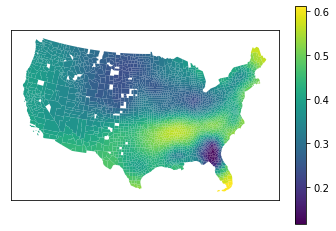

In [30]:
# Visualizing local R2 values on a map

covid_IR2['R2'] = gwr_results.localR2
covid_IR2.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
# Create a column to store standardized residual values in the dataframe

covid_IR2['SR'] = gwr_results.std_res

In [32]:
covid_IR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,CARDIO_MR,OBESE_PCT,IR2_log,Shape_Leng,Shape_Area,X,Y,geometry,R2,SR
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,391.5,39.4,2.451193,153989.870317,1.481950e+09,-65040.900019,324120.335166,"POLYGON ((-84104.520 334058.032, -84103.729 33...",0.303681,-0.219855
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,186.9,29.9,2.752805,191498.450302,2.181031e+09,-57758.726637,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.323487,0.005572
2,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,548.3,35.6,1.984221,154088.963652,1.483452e+09,-173426.738663,132548.110644,"POLYGON ((-192849.850 123355.389, -192849.816 ...",0.314053,-0.643062
3,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,229.2,31.1,2.614508,186372.852811,2.103144e+09,-63679.933739,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.269650,-0.392223
4,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,None,...,342.1,29.1,2.874112,204909.652555,2.346750e+09,-366739.340990,-892066.944835,"POLYGON ((-365946.769 -870192.658, -365650.326...",0.414429,1.072694


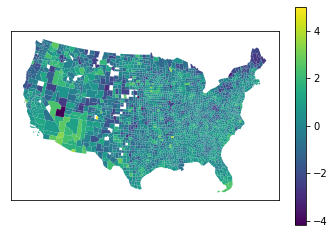

In [33]:
# Visualizing standardized residuals on a map

covid_IR2['SR'] = gwr_results.std_res
covid_IR2.plot('SR', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
# Reviewing parameter estimates associated with the predictors starting with the constant.
# B coefficients follow the sequence of predictors listed in code sample for running OLS

print(gwr_results.params)

[[ 3.42051640e+00 -2.91233040e-02 -1.92100095e-02 -7.08721266e-03
  -1.27870941e-06  7.43637734e-03]
 [ 3.38296963e+00 -2.45975765e-02 -3.10116738e-02 -3.14546459e-03
  -1.86382645e-05  5.76076721e-03]
 [ 3.35100421e+00 -2.04769184e-02 -3.70347392e-02  2.99649115e-03
  -3.51703339e-05  1.81009171e-03]
 ...
 [ 3.18425934e+00 -1.42676098e-02 -6.21984067e-02  7.77708432e-03
   5.66626305e-04  1.11885576e-02]
 [ 3.69959106e+00 -2.31228731e-02 -2.72156817e-02  9.67155363e-03
   7.65445917e-05 -5.28147719e-03]
 [ 3.83916259e+00 -2.50772245e-02 -1.25253623e-02  2.83855556e-03
   2.04014912e-04 -1.65326376e-02]]


<a id='Ref'></a>
### References

Environmental Systems Research Institute (ESRI). (2021). How Geographically Weighted Regression (GWR) works. https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/how-geographicallyweightedregression-works.htm#GUID-A5307DAE-12AF-41C2-831B-10192ECB6CE4. Accessed Jun 15th, 2021

Fotheringham, A.S., Brunsdon, C., and Charlton, M. (2002). Geographically Weighted Regression. West Sussex, U.K.: John Wiley & Sons Ltd. 

Multiscale Geographically Weighted Regression (MGWR). (2018). https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWRResults.html#mgwr.gwr.GWRResults. Accessed Jun 15th, 2021

Ndiath, M.M., Cisse, B., Ndiaye, J.L., Gomis, J.F., Bathiery, O., Dia, A. T., Gaye, O., and Faye, B. (2015).Application of geographically‑weighted regression analysis to assess risk factors for malaria hotspots in Keur Soce health and demographic surveillance site. Malaria Journal, 14:463. doi:10.1186/s12936-015-0976-9

Oshan, T.M., Li, Z., Kang, W., Wolf, L.J., and Fotheringham, A.S. (2019). MGWR: A Python Implementation of Multiscale
GeographicallyWeighted Regression for Investigating Process Spatial Heterogeneity and Scale. International Journal of Geo-Information, 8:269. doi:10.3390/ijgi8060269

Spatial Regression Models (spreg). (2018). https://pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS. Accessed Jun 15th, 2021


